# Resnet random weight allocation

This notebook implements case 3 of the document: https://mit.zoom.us/j/98140955616
It clusters the training (Bias_0.8) training data into 5 groups, one of them containnig the protceted group (either female for doctors or male for nurses). During model training, we assign the same weight to every group except for one, where the weight is 4 times the others. We hope that this procedure will increase the fairness performance from Case 1 (Normal training on Bias_0.8 dataset)

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import time
import os
import copy
import visdom
import pandas as pd
from math import ceil
from PIL import Image

plt.ion()   # interactive mode

In [4]:
path_dr_f_d = '../Datasets/doctor_nurse/dr/fem_dr_dark_56/'
path_dr_f_l = '../Datasets/doctor_nurse/dr/fem_dr_light_256/'
path_dr_m_d = '../Datasets/doctor_nurse/dr/mal_dr_dark_62/'
path_dr_m_l = '../Datasets/doctor_nurse/dr/mal_dr_light_308/'

dr_f_d = os.listdir(path_dr_f_d)
dr_f_l = os.listdir(path_dr_f_l)
dr_m_d = os.listdir(path_dr_m_d)
dr_m_l = os.listdir(path_dr_m_l)

path_nur_f_d = '../Datasets/doctor_nurse/nurse/fem_nurse_dark_63/'
path_nur_f_l = '../Datasets/doctor_nurse/nurse/fem_nurse_light_252/'
path_nur_m_d = '../Datasets/doctor_nurse/nurse/mal_nurse_dark_76/'
path_nur_m_l = '../Datasets/doctor_nurse/nurse/mal_nurse_light_203/'

nur_f_d = os.listdir(path_nur_f_d)
nur_f_l = os.listdir(path_nur_f_l)
nur_m_d = os.listdir(path_nur_m_d)
nur_m_l = os.listdir(path_nur_m_l)

dr_m, dr_f = len(dr_m_d) + len(dr_m_l), len(dr_f_d) + len(dr_f_l)

w_protected = 4

###  Defining dataloaders

In [43]:
def chunks(lst, K):
    """Yield successive K-sized chunks from lst."""
    results, n = [], ceil(len(lst)/K)
    for i in range(0, len(lst), n):
        results.append(lst[i:(i + n) if i + n < len(lst) else None])
    return results

def make_clusters(sets, protected_groups, K):
    assert len(sets) == len(protected_groups)
    
    clusters = []
    for i, s in enumerate(sets):
        majority, minority = [], []
        for img in s:
            minority.append(img) if img in protected_groups[i] else majority.append(img)
        
        clusters.append(chunks(majority, K-1) + [minority])
        
    return clusters



In [44]:
class my_ImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform, clusters):
        super().__init__(root, transform)
        self.clusters = clusters
        
    def __getitem__(self, index: int):
        img = self.samples[index][0].split("/")[-1]
        group_number = max([[img in c for c in clusters].index(max([img in c for c in clusters])) for clusters in self.clusters])
        return super().__getitem__(index), group_number

In [45]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


BIAS = 0.8
data_dir = '../Datasets/doctor_nurse/train_test_split'
image_datasets = {x: my_ImageFolder(os.path.join(data_dir, f"train_{BIAS}" if x=="train" and BIAS else x), 
                                    data_transforms[x], 
                                    make_clusters([os.listdir(os.path.join(data_dir, f"train_{BIAS}/doctors" if x=="train" and BIAS else x)),
                                                    os.listdir(os.path.join(data_dir, f"train_{BIAS}/nurses" if x=="train" and BIAS else x))],
                                                    [set(dr_f_d + dr_f_l), set(nur_m_l + nur_m_d)],
                                                      K=2))
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

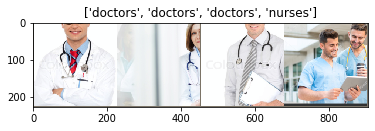

tensor([0, 0, 0, 1])
tensor([0, 1, 0, 1])


In [48]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
(inputs, classes), groups = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print(classes)
print(groups)

## Training and evaluation of ResNet 

Note that to be able to visualize the training progress, you must have started a vsdom environment in a browser. The plots will show up there.

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, start_epoch=0, val_mode=False, show_progress=False, weighted=False):
    
    if show_progress:
        vis = visdom.Visdom()
        loss_window = vis.line(X=np.ones((1))*start_epoch,
                               Y=np.zeros((1, 2)) if val_mode else np.zeros((1)),
                               opts=dict(xlabel='epoch',
                                         ylabel='Loss',
                                         title='epoch loss',
                                         markers=True,
                                         legend=["Train", "Val"] if val_mode else ["Train"],
                                         ))   
        acc_window = vis.line(X=np.ones((1))*start_epoch,
                               Y=np.zeros((1, 2)) if val_mode else np.zeros((1)),
                               opts=dict(xlabel='epoch',
                                         ylabel='Accuracy',
                                         title='epoch accuracy',
                                         markers=True,
                                         legend=["Train", "Val"] if val_mode else ["Train"],
                                        ))  
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(start_epoch, start_epoch + num_epochs):
        losses, accuracies = {}, {}
        print('Epoch {}/{}'.format(epoch, start_epoch + num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        phases = ['train', 'val'] if val_mode else ["train"]
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for (inputs, labels), groups in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    weights = torch.tensor([w_protected if g == epoch%2 else 1 for g in groups.numpy()])
                    loss = criterion(outputs, labels, weights)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase] = epoch_loss
            accuracies[phase] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
        if show_progress:
            X1 = np.ones((1))*epoch

            Y1 = np.array([losses["train"]])
            Y2 = np.array(losses["val"]) if val_mode else None
            vis.line(X=X1,Y=np.column_stack((Y1, Y2)) if val_mode else Y1,win=loss_window,update='append')

            Y1 = np.array([accuracies["train"]])
            Y2 = np.array([accuracies["val"]]) if val_mode else None
            vis.line(X=X1,Y=np.column_stack((Y1, Y2)) if val_mode else Y1, win=acc_window, update='append')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    if "val" in phases:
        model.load_state_dict(best_model_wts)
        
    return model

## Vizualize model

In [38]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, ((inputs, labels), groups) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, Actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Freezing all layers except last FC

#### Custom loss

In [39]:
def weighted_cross_entropy_loss(output, labels, weights):
    cel = -torch.log(torch.exp(output.gather(1, labels.view(-1,1))) / torch.sum(torch.exp(output), 1).view(-1,1))
    weighted_cel = weights * cel.view(-1)
    return torch.mean(weighted_cel)

For descirption of architecture of resNet, see: https://arxiv.org/pdf/1512.03385.pdf

In [40]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = weighted_cross_entropy_loss # nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Training

#### Loading checkpoint

In [41]:
VAL_MODE = False
SHOW = False
START_EPOCH = 0
EPOCH = 30
id = 20

In [32]:
START_EPOCH = 15
id = 1
PATH =  "Case_3/checkpoints/" + ("w_val" if VAL_MODE else "w.o_val") + f"/Bias_{BIAS}/model_ep_{START_EPOCH}/Run_{id}/checkpoint.pt"
checkpoint = torch.load(PATH)
model_conv.load_state_dict(checkpoint['model_state_dict'])
optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
exp_lr_scheduler.load_state_dict(checkpoint["lr_scheduler_state_dict"])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [42]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, start_epoch=START_EPOCH, num_epochs=EPOCH, val_mode=VAL_MODE, show_progress=SHOW)

Epoch 0/29
----------
tensor([0, 0, 0, 0]) tensor([4, 4, 4, 4])

Epoch 1/29
----------
tensor([1, 0, 1, 1]) tensor([4, 1, 4, 4])

Epoch 2/29
----------
tensor([1, 1, 1, 0]) tensor([1, 1, 1, 4])

Epoch 3/29
----------
tensor([0, 1, 1, 1]) tensor([1, 4, 4, 4])

Epoch 4/29
----------
tensor([1, 1, 1, 1]) tensor([1, 1, 1, 1])

Epoch 5/29
----------
tensor([1, 0, 0, 1]) tensor([4, 1, 1, 4])

Epoch 6/29
----------
tensor([1, 0, 1, 1]) tensor([1, 4, 1, 1])

Epoch 7/29
----------
tensor([1, 0, 0, 0]) tensor([4, 1, 1, 1])

Epoch 8/29
----------
tensor([1, 1, 1, 1]) tensor([1, 1, 1, 1])

Epoch 9/29
----------
tensor([0, 1, 0, 1]) tensor([1, 4, 1, 4])

Epoch 10/29
----------
tensor([1, 0, 0, 1]) tensor([1, 4, 4, 1])

Epoch 11/29
----------
tensor([1, 0, 1, 0]) tensor([4, 1, 4, 1])

Epoch 12/29
----------
tensor([1, 1, 0, 1]) tensor([1, 1, 4, 1])

Epoch 13/29
----------
tensor([1, 1, 0, 1]) tensor([4, 4, 1, 4])

Epoch 14/29
----------
tensor([1, 0, 0, 1]) tensor([1, 4, 4, 1])

Epoch 15/29
--------

/home/ghayat/.local/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


tensor([1, 1, 1, 0]) tensor([4, 4, 4, 1])

Training complete in 0m 27s
Best val Acc: 0.000000


### Visualizing results 

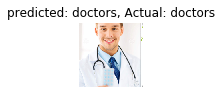

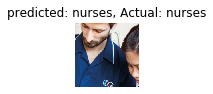

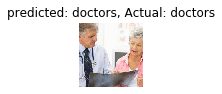

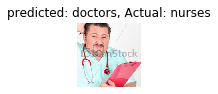

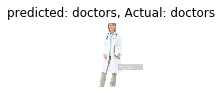

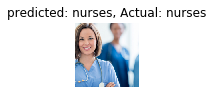

In [32]:
visualize_model(model_conv, dataloader=dataloaders["test"], num_images=6)

plt.ioff()
plt.show()

#### Saving checkpoint

In [18]:
PATH =  "Case_3/checkpoints/" + ("w_val" if VAL_MODE else "w.o_val") + f"/Bias_{BIAS}/model_ep_{START_EPOCH + EPOCH}/Run_{id}"
LOSS = "CrossEntropyLoss"

os.makedirs(PATH, exist_ok=True)
torch.save({
            'epoch': START_EPOCH + EPOCH,
            'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'lr_scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            'loss': LOSS,
            }, PATH + "/checkpoint.pt")

Connection is already closed.
Connection is already closed.
Connection is already closed.
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
